# Making Artificial Images

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ArtificialStellarPopulations/ArtPop/blob/main/colab_tutorials/artimages.ipynb)

Once you have created a [Source](source.ipynb) object, you are ready to use **ArtPop** to "observe" it and make an artificial image. Mock observations in **ArtPop** are carried out using ``Imager`` objects, which are the topic of this tutorial. 

**Note:** To generate MIST synthetic photometry using **ArtPop**, [MIST isochrone grids](../getting_started/mist.rst) are required. The first time you use a MIST grid, **ArtPop** will download it and save it to your `MIST_PATH`. If this environmental variable is not set, the grid(s) will be saved in `~/.artpop/mist`.

In [1]:
# Third-party imports 
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u   
from astropy.visualization import make_lupton_rgb

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(14)

## IdealImager

The [IdealImager](../api/artpop.image.IdealImager.rst) is an imager object for creating noiseless images. 

First, we need to create a ``Source`` to observe. In this tutorial, we'll simulate an SSP with a Sersic spatial distribution using the helper [MISTSersicSSP](../api/artpop.source.MISTSersicSSP.rst) class:

In [2]:
src = artpop.MISTSersicSSP(
    log_age = 10,         # log of age in years
    feh = -1.5,           # metallicity [Fe/H]
    r_eff = 300 * u.pc,   # effective radius
    n = 0.8,              # Sersic index
    theta = 45 * u.deg,   # position angle
    ellip = 0.3,          # ellipticity
    num_stars = 5e6,      # number of stars
    phot_system = 'LSST', # photometric system 
    distance = 5 * u.Mpc, # distance to system 
    xy_dim = 651,         # image dimension
    pixel_scale = 0.2,    # pixel scale in arcsec / pixel  
    random_state = rng    # random state for reproducibility
)

Next, we initialize an `IdealImager`with the photometric system name(s) and generate a Moffat point spread function (PSF) using the [moffat_psf](../api/artpop.image.moffat_psf.rst) function. Note the PSF is given as an [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html#numpy.ndarray), which makes it possible to use an observed PSF if you have one. 

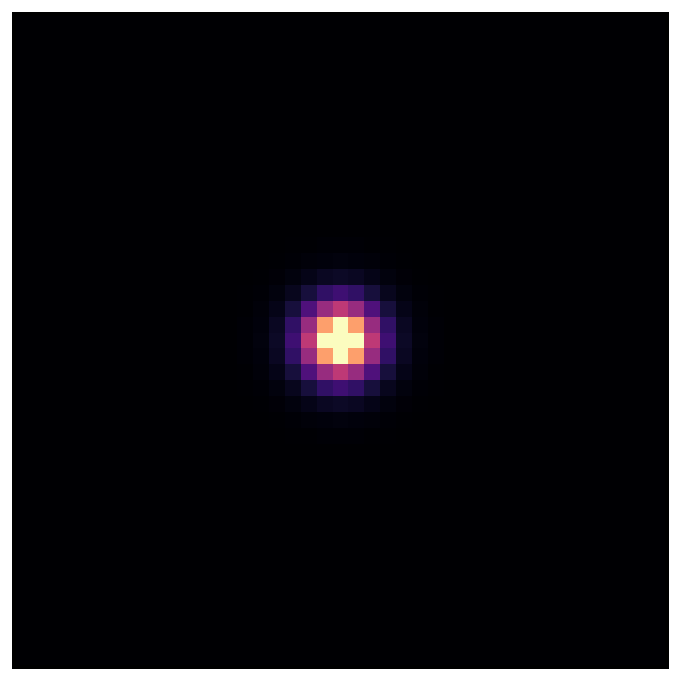

In [3]:
# initialize IdealImager with the LSST phot_system
imager = artpop.IdealImager()

# create PSF with 0.7'' seeing
psf = artpop.moffat_psf(fwhm=0.7*u.arcsec)

# display PSF using ArtPop's show_image function
artpop.show_image(psf, figsize=(6, 6), cmap='magma');

Finally, we create a synthetic $i$-band observation using the ``IdealImager``'s [observe](../api/artpop.image.IdealImager.rst#artpop.image.IdealImager.observe) method. The returned observation ``obs`` is an [IdealObservation](../api/artpop.image.IdealObservation.rst) object with attributes ``image`` (the mock image pixels), ``zpt`` (the zero point), and ``bandpass``. 

In [4]:
# mock observe the source
obs = imager.observe(src, bandpass='LSST_i', psf=psf, zpt=27)

Here's the image displayed using the ArtPop's [show_image](../api/artpop.visualization.show_image.rst) function:

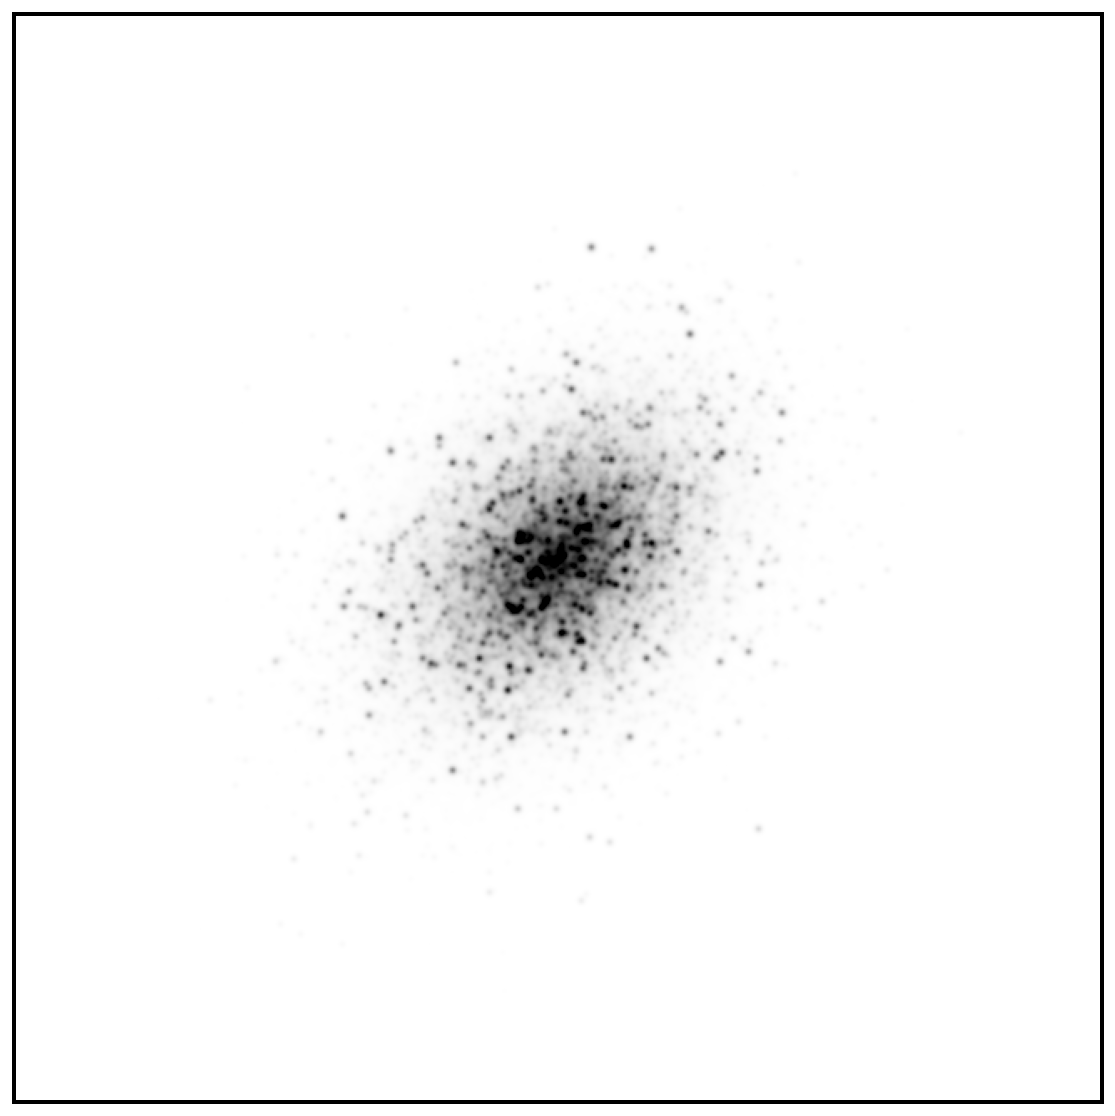

In [5]:
artpop.show_image(obs.image);

## ArtImager

The **Art**ificial **Imager**, [ArtImager](https://artpop.readthedocs.io/en/latest/api/artpop.image.ArtImager.html), is an imager that creates fully artificial images with realistic noise. In order to calculate the noise, parameters about the instrument, exposure time, and sky surface brightness are required. 

Here we create an ``ArtImager`` object with parameters similar to what is expected for LSST and the Rubin Observatory:

In [6]:
imager = artpop.ArtImager(
    phot_system = 'LSST', # photometric system
    diameter = 6.4 * u.m, # effective aperture diameter
    read_noise = 4,       # read noise in electrons
    random_state = rng    # random state for reproducibility 
)

Similar to the ``IdealImager``, we create a mock observation using the ``ArtImager``'s [observe](https://artpop.readthedocs.io/en/latest/api/artpop.image.ArtImager.html#artpop.image.ArtImager.observe) method. The difference is that in this case, we must also provide the exposure time and sky surface brightness. Let's observe the same source as above with a sky that's similar to dark time at Cerro Pachon ([Abbott et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJS..239...18A/abstract)):

In [7]:
# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(src, 'LSST_g', 30 * u.min, sky_sb=22, psf=psf)
obs_r = imager.observe(src, 'LSST_r', 30 * u.min, sky_sb=21, psf=psf)
obs_i = imager.observe(src, 'LSST_i', 1 * u.hr, sky_sb=20, psf=psf)

To make a pretty picture, we'll use astropy's [make_lupton_rgb](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html) function:

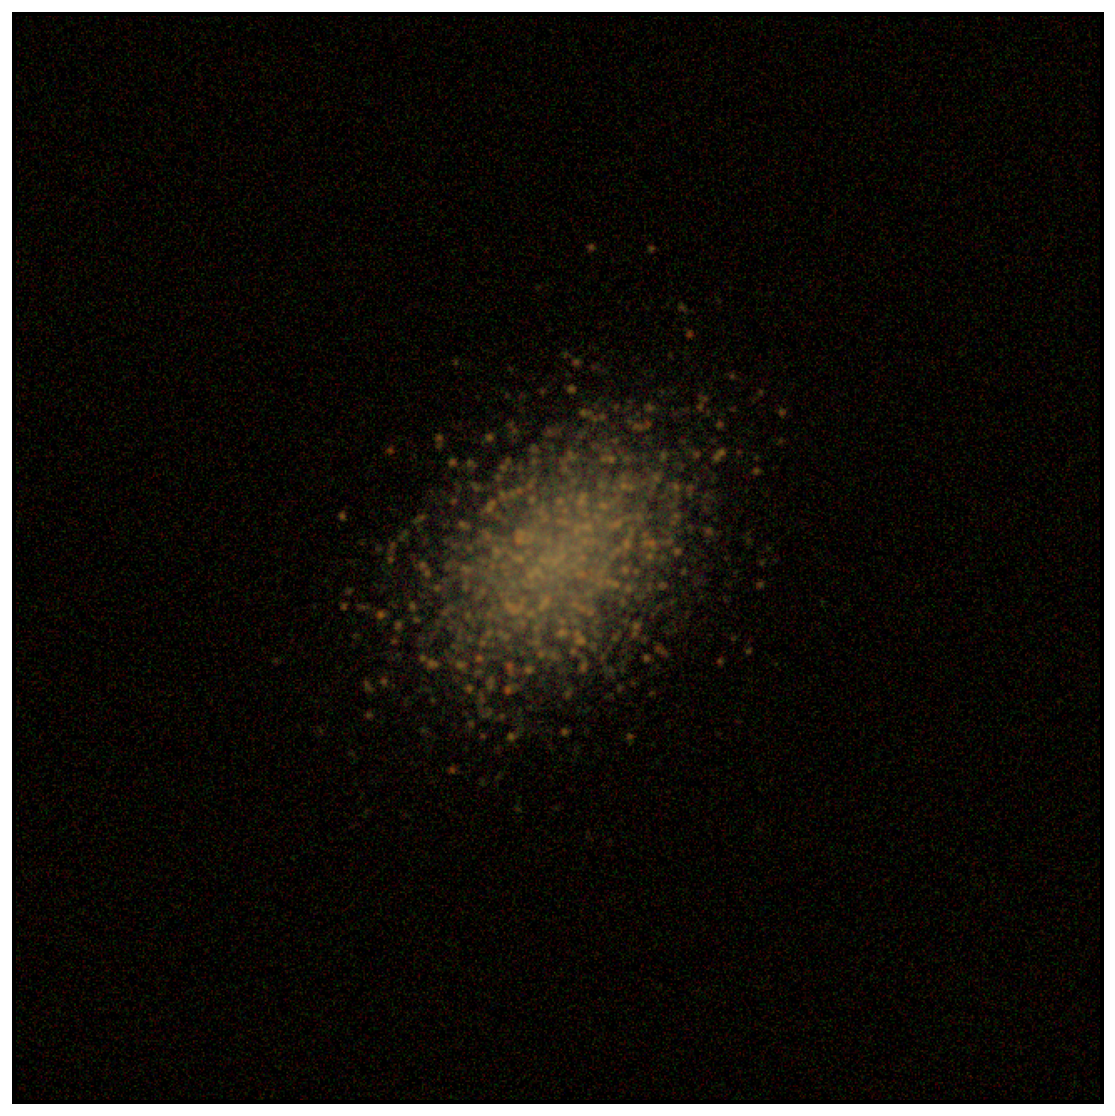

In [8]:
rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

artpop.show_image(rgb);